In [68]:
# Load data and import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import joblib

discharge_df = pd.read_csv('../data/discharge_df.csv')
discharge_df['start_datetime'] = pd.to_datetime(discharge_df['start_datetime'])
discharge_df['Capacity'] = pd.to_numeric(discharge_df['Capacity'], errors='coerce')
discharge_df['capacity_diff'] = discharge_df.groupby('battery_id')['Capacity'].diff()

sample_batteries = discharge_df['battery_id'].unique()[:4]


In [69]:
# Define function to load saved model

def load_model(battery_id):
    model_path = f'../results/models/{battery_id}_arima.pkl'
    model = joblib.load(model_path)
    return model


In [70]:
# Forecast next 20 steps on actual Capacity, not differenced values

def forecast_real_capacity(model_fit, last_known_capacity):
    forecast_result = model_fit.get_forecast(steps=20)
    pred_mean_diff = forecast_result.predicted_mean
    conf_int_diff = forecast_result.conf_int()

    # Cumulative sum to invert differencing
    pred_capacity = last_known_capacity + pred_mean_diff.cumsum()
    
    # Adjust confidence intervals
    conf_int_capacity = conf_int_diff.copy()
    conf_int_capacity.iloc[:,0] = last_known_capacity + conf_int_diff.iloc[:,0].cumsum()
    conf_int_capacity.iloc[:,1] = last_known_capacity + conf_int_diff.iloc[:,1].cumsum()
    
    return pred_capacity, conf_int_capacity


In [71]:
# Beautiful 2x2 grid plot of real Capacity forecasts for all sample batteries

def plot_forecasts_grid(sample_batteries, discharge_df):
    import matplotlib.pyplot as plt
    import joblib
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for idx, battery_id in enumerate(sample_batteries):
        temp = discharge_df[discharge_df['battery_id'] == battery_id]
        series_actual = temp['Capacity'].dropna().reset_index(drop=True)
        
        model_fit = load_model(battery_id)
        last_known_capacity = series_actual.iloc[-1]
        forecast_capacity, conf_int_capacity = forecast_real_capacity(model_fit, last_known_capacity)
        
        forecast_index = range(series_actual.index[-1]+1, series_actual.index[-1]+1+len(forecast_capacity))
        
        # Plot observed
        axes[idx].plot(series_actual.index, series_actual.values, color='b', linewidth=2, label='Observed Capacity')
        
        # Plot forecast
        axes[idx].plot(forecast_index, forecast_capacity, color='red', linestyle='-', linewidth=2, label='Forecasted Capacity')
        
        # Fill confidence interval
        axes[idx].fill_between(forecast_index, 
                               conf_int_capacity.iloc[:,0], conf_int_capacity.iloc[:,1],
                               color='skyblue', alpha=0.3)
        
        axes[idx].set_title(f'Battery {battery_id}', fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Cycle Number', fontsize=12)
        axes[idx].set_ylabel('Capacity (Ah)', fontsize=12)
        axes[idx].legend(fontsize=10, frameon=True, facecolor='white', edgecolor='black')
        axes[idx].grid(True, linestyle='--', alpha=0.5)
        
    plt.tight_layout()
    plt.show()


/Users/parthsarthisrivastava/Library/CloudStorage/OneDrive-stevens.edu/Classes/Spring '25/stevens/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/parthsarthisrivastava/Library/CloudStorage/OneDrive-stevens.edu/Classes/Spring '25/stevens/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/parthsarthisrivastava/Library/CloudStorage/OneDrive-stevens.edu/Classes/Spring '25/stevens/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users

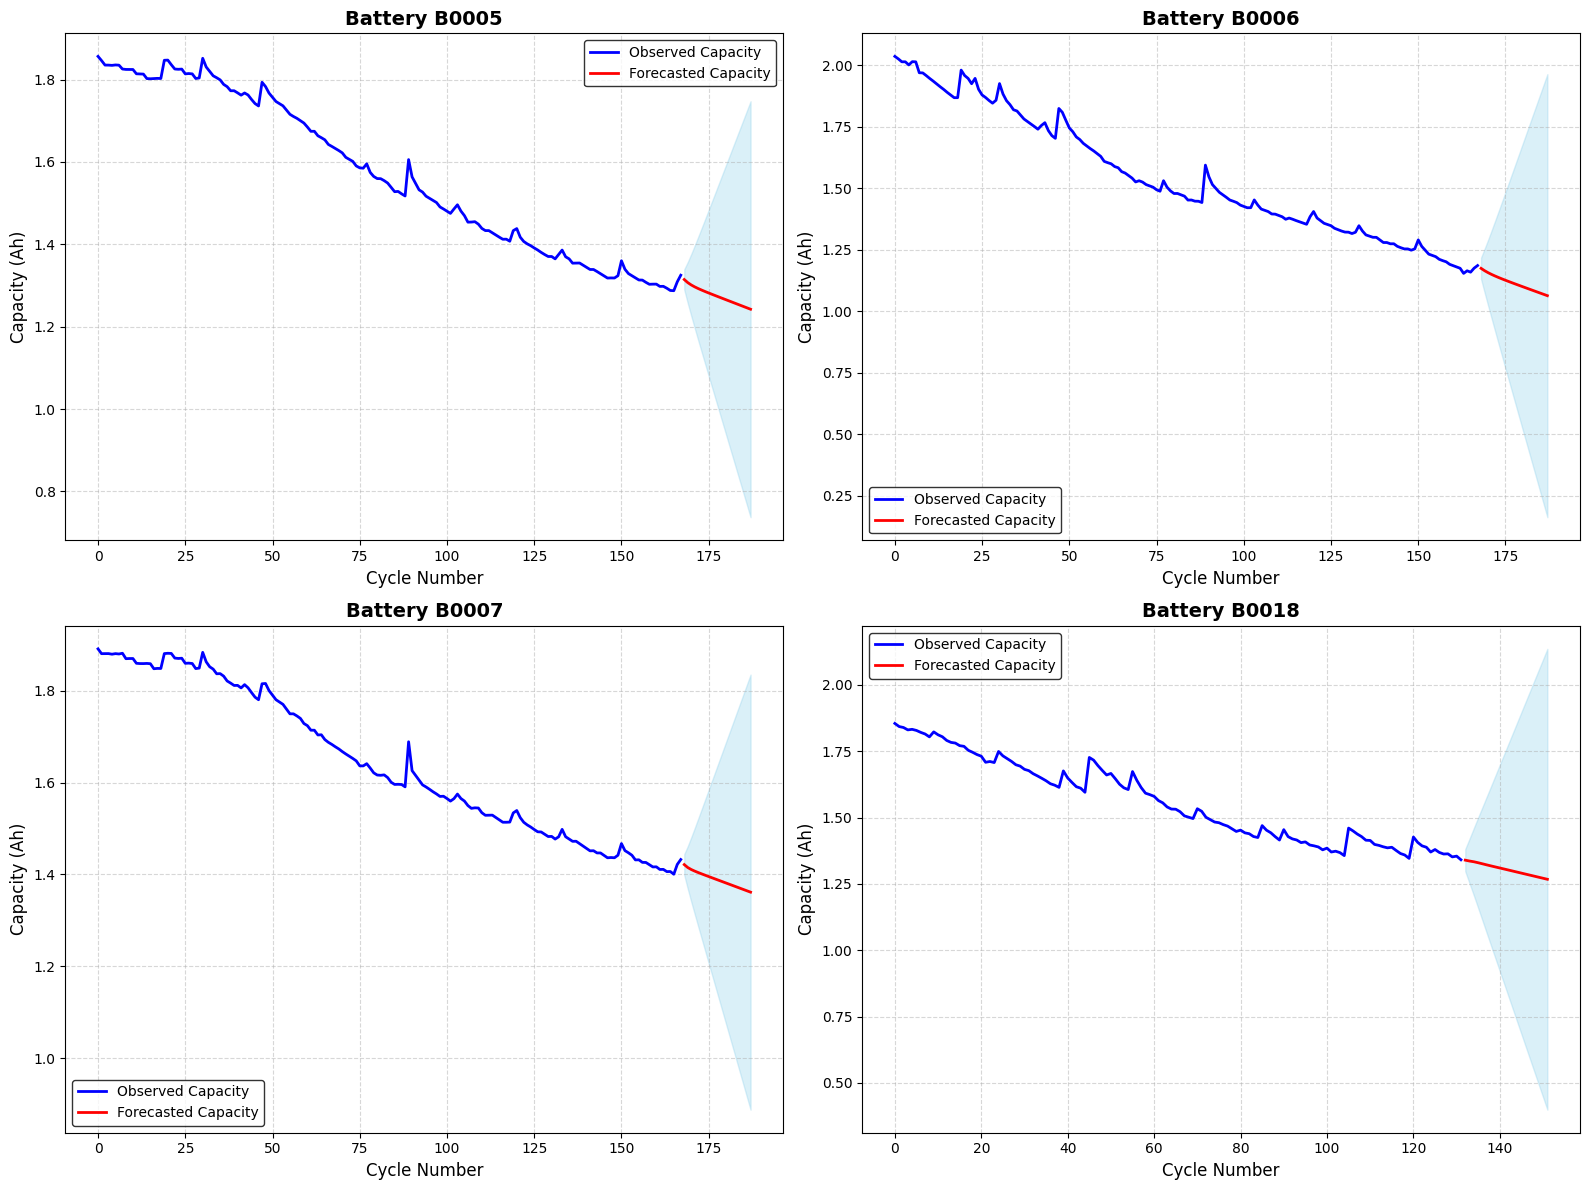

In [72]:
# Final beautiful 2x2 forecasting plot for all 4 batteries

plot_forecasts_grid(sample_batteries, discharge_df)


In [73]:
# Loop through all fitted models and print their full statistical summary

for battery_id in sample_batteries:
    print(f"\n        ------------ ARIMA Model Summary for Battery {battery_id} ------------\n")
    
    model_fit = load_model(battery_id)
    
    print(model_fit.summary())
    print("\n" + "="*100 + "\n")



        ------------ ARIMA Model Summary for Battery B0005 ------------

                               SARIMAX Results                                
Dep. Variable:          capacity_diff   No. Observations:                  167
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 493.459
Date:                Mon, 28 Apr 2025   AIC                           -978.918
Time:                        17:56:01   BIC                           -966.446
Sample:                             0   HQIC                          -973.856
                                - 167                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.001     -2.954      0.003      -0.005      -0.001
ar.L1          0.5800      0.219      2.652      0.008   

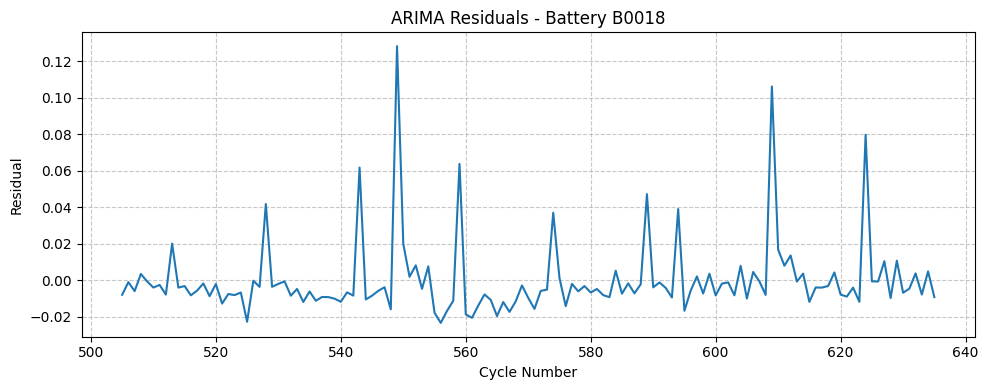

In [ ]:
# Load ARIMA residuals for B0018
import joblib
from arch import arch_model
import matplotlib.pyplot as plt

battery_id = 'B0018'

# Load the fitted ARIMA model
model_fit = load_model(battery_id)

# Get residuals
residuals = model_fit.resid.dropna()

# Plot residuals before fitting GARCH
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title(f'ARIMA Residuals - Battery {battery_id}')
plt.xlabel('Cycle Number')
plt.ylabel('Residual')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [75]:
# Step 2: Fit GARCH(1,1) Model on residuals

garch_model = arch_model(residuals, vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')
# Step 3: Print GARCH Summary
print(garch_fit.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                319.300
Distribution:                  Normal   AIC:                          -630.599
Method:            Maximum Likelihood   BIC:                          -619.099
                                        No. Observations:                  131
Date:                Mon, Apr 28 2025   Df Residuals:                      130
Time:                        17:56:01   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.9888e-05  2.763e-03  2.529e-02      0.980 

/Users/parthsarthisrivastava/Library/CloudStorage/OneDrive-stevens.edu/Classes/Spring '25/stevens/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004531. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
